In [1]:
import numpy as np
import imageio
from softlearning.models.state_estimation import (
    state_estimator_model, get_dumped_pkl_data, get_seed_data, train)
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Choosing the latest nvidia driver: /usr/lib/nvidia-384, among ['/usr/lib/nvidia-000', '/usr/lib/nvidia-384']
Choosing the latest nvidia driver: /usr/lib/nvidia-384, among ['/usr/lib/nvidia-000', '/usr/lib/nvidia-384']


In [2]:
image_shape = (32, 32, 3)

obs_keys = ('object_position',
            'object_orientation_cos',
            'object_orientation_sin')
model = state_estimator_model(
    domain='DClaw',
    task='TurnFreeValve3ResetFreeSwapGoal-v0',
    obs_keys_to_estimate=obs_keys, 
    input_shape=image_shape)

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='mean_squared_error')

W0819 22:03:25.369427 140098398820160 deprecation.py:506] From /opt/conda/envs/vice/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "state_estimator_preprocessor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
convnet_preprocessor (Pickla (None, 256)               112576    
_________________________________________________________________
feedforward_model (Picklable (None, 4)                 132612    
Total params: 245,188
Trainable params: 245,188
Non-trainable params: 0
_________________________________________________________________


Train on 475047 samples, validate on 25003 samples
Epoch 1/5
475047/475047 [==============================] - 46s 96us/sample - loss: 0.4226 - val_loss: 0.0078
Epoch 2/5
475047/475047 [==============================] - 42s 89us/sample - loss: 0.0052 - val_loss: 0.0042
Epoch 3/5
475047/475047 [==============================] - 43s 91us/sample - loss: 0.0038 - val_loss: 0.0034
Epoch 4/5
475047/475047 [==============================] - 42s 89us/sample - loss: 0.0031 - val_loss: 0.0026
Epoch 5/5
475047/475047 [==============================] - 42s 89us/sample - loss: 0.0027 - val_loss: 0.0030

========== IMAGE # 0 =========
POS ERROR (cm): 0.48182654693532556 true xy: [ 0.71230762 -0.14425135] pred xy: [ 0.7068149 -0.1548195]
ANGLE ERROR (degrees): 1.9625827391296227 true angle: -130.2219180039654 pred angle: -132.18450074309504

========== IMAGE # 1 =========
POS ERROR (cm): 2.449980202814006 true xy: [0.70847127 0.54922796] pred xy: [0.7237085  0.61565673]
ANGLE ERROR (degrees): 1.066576

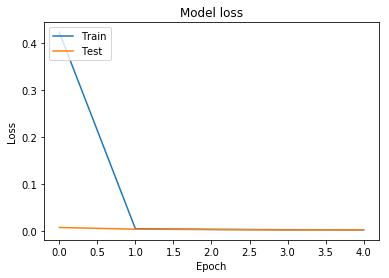

In [3]:
train(model, obs_keys, './state_estimator_test.h5', n_epochs=5)

In [3]:
# weights_path = './state_estimator_random_data_50_epochs.h5'
weights_path = './state_estimator_invisible_claw.h5'
model.load_weights(weights_path)

In [121]:
# training_pools_base_path = '/root/softlearning-vice/goal_classifier/free_screw_state_estimator_data/all_data.pkl' 
training_pools_base_path = '/root/softlearning-vice/goal_classifier/free_screw_state_estimator_data_invisible_claw/data.pkl'
images, labels = get_dumped_pkl_data(training_pools_base_path)
# images, labels = get_training_data(training_pools_base_path, limit=1)

In [6]:
training_pools_base_path = '/root/softlearning-vice/goal_classifier/free_screw_state_estimator_data_invisible_claw_test/data.pkl'
images, labels = get_dumped_pkl_data(training_pools_base_path)

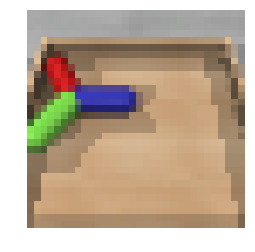

In [7]:
plt.axis('off')
plt.imshow(images[209])

In [ ]:
training_pools_base_path = '/home/justinvyu/ray_results/gym/DClaw/TurnFreeValve3ResetFreeSwapGoal-v0/2019-08-07T14-57-41-state_gtr_2_goals_with_resets_regular_box_saving_pixels_fixed_env/id=612875d0-seed=9463_2019-08-07_14-57-42op75_8n7'
images, labels = get_seed_data(training_pools_base_path)

In [8]:
random_indices = np.random.randint(images.shape[0], size=2000)
test_images = images[random_indices]
test_labels = labels[random_indices]
preds = model.predict(test_images)

In [8]:
pos_errors = []
angle_errors = []

degrees = lambda x: x * 180 / np.pi
def angle_distance(deg1, deg2):
    phi = np.abs(deg1 - deg2) % 360
    distance = 360 - phi if phi > 180 else phi
    return distance

for i, (test_img, label, pred) in enumerate(zip(test_images, test_labels, preds)):
    pos_error_xy = np.abs(label[:2] - pred[:2])
    pos_error = np.linalg.norm(pos_error_xy)
    pos_error = 15 * pos_error # free box is 30 cm, 15 on each side (-1 -> 1 --> -15 -> 15)
    
    true_angle = np.arctan2(label[3], label[2])
    true_angle = degrees(true_angle)
    pred_angle = np.arctan2(pred[3], pred[2])
    pred_angle = degrees(pred_angle)
    
    angle_error = angle_distance(true_angle, pred_angle)

    pos_errors.append(pos_error)
    angle_errors.append(angle_error)

#     print('\n========== IMAGE #', i, '=========')
#     print('POS ERROR (cm):', pos_error, 'true xy: {}'.format(label[:2]), 'pred xy: {}'.format(pred[:2]))
#     print('ANGLE ERROR (degrees):', angle_error, 'true angle: {}'.format(true_angle), 'pred angle: {}'.format(pred_angle))
#     imageio.imwrite(f'/root/imgs/test{i}.jpg', test_img)

mean_pos_error = np.mean(pos_errors)
mean_angle_error = np.mean(angle_errors)
print('MEAN POS ERROR (CM):', mean_pos_error)
print('MEAN ANGLE ERROR (degrees):', mean_angle_error)

MEAN POS ERROR (CM): 0.18950453271591358
MEAN ANGLE ERROR (degrees): 0.6205985976003665



========== IMAGE # 0 =========
POS (cm) ERROR: 0.6640608259680626

true: [ 0.28609286 -0.14521796 -0.01334713 -0.99991092]
pred: [ 0.25374267 -0.17543983 -0.01776893 -0.98513126]


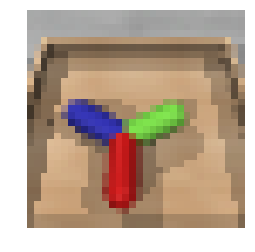


========== IMAGE # 1 =========
POS (cm) ERROR: 0.6626837349982589

true: [-0.54944928 -0.10932818 -0.05491104  0.99849125]
pred: [-0.5587558  -0.06614062 -0.04203973  0.986967  ]


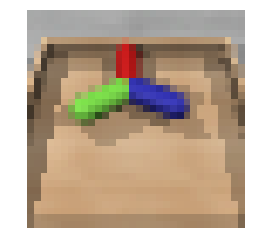


========== IMAGE # 2 =========
POS (cm) ERROR: 0.6194166339231496

true: [ 0.41490305 -0.1247519  -0.01982408 -0.99980348]
pred: [ 0.38361418 -0.15170069 -0.00344446 -0.9885765 ]


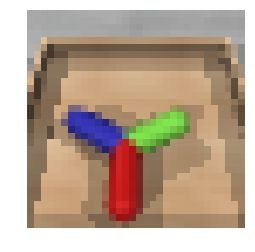


========== IMAGE # 3 =========
POS (cm) ERROR: 0.6192168148157307

true: [ 0.42619004  0.04522876  0.00912803 -0.99995834]
pred: [ 0.40255752  0.01138153  0.02163129 -0.9882883 ]


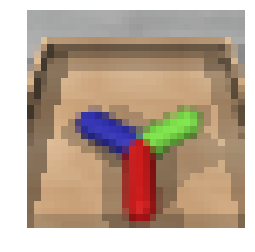


========== IMAGE # 4 =========
POS (cm) ERROR: 0.6058318928166604

true: [ 0.30201641 -0.10647405  0.00823749 -0.99996607]
pred: [ 0.28007963 -0.14038618  0.00423795 -0.9860418 ]


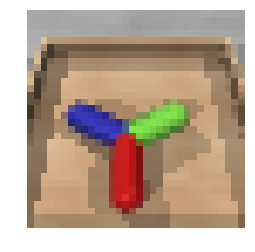


========== IMAGE # 5 =========
POS (cm) ERROR: 0.6012354520785779

true: [ 0.55467714  0.39020524 -0.15817582 -0.98741096]
pred: [ 0.53037226  0.35833254 -0.15081425 -0.9806032 ]


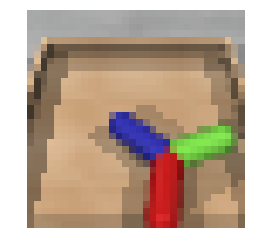


========== IMAGE # 6 =========
POS (cm) ERROR: 0.5924518736686506

true: [-0.47583388  0.18991975 -0.20815023  0.97809687]
pred: [-0.4829264   0.22877452 -0.19101886  0.9735599 ]


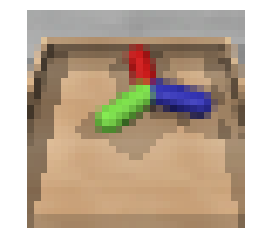


========== IMAGE # 7 =========
POS (cm) ERROR: 0.5920234925626295

true: [ 0.49737283  0.30167653 -0.98024362 -0.19779396]
pred: [ 0.499391    0.26225993 -0.9793601  -0.17445016]


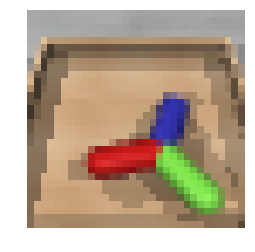


========== IMAGE # 8 =========
POS (cm) ERROR: 0.5911651031084534

true: [ 0.42700211  0.05325577  0.06915834 -0.9976057 ]
pred: [ 0.40679163  0.01942141  0.08010729 -0.98671824]


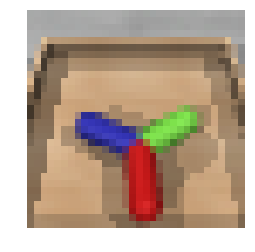


========== IMAGE # 9 =========
POS (cm) ERROR: 0.5902060353894775

true: [ 0.43913476  0.49391846  0.10847505 -0.99409917]
pred: [ 0.4108846   0.46653014  0.10879141 -0.9858903 ]


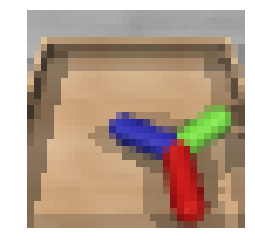


========== IMAGE # 10 =========
POS (cm) ERROR: 0.5892083822465038

true: [ 0.55236834  0.12983356 -0.00319724 -0.99999489]
pred: [ 0.5256921   0.10100058 -0.00635822 -0.9862274 ]


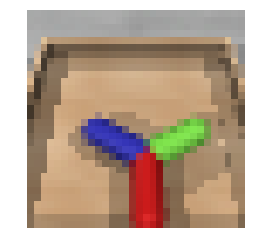


========== IMAGE # 11 =========
POS (cm) ERROR: 0.5892057258788304

true: [-0.85918765  0.24805629 -0.83005859  0.5576762 ]
pred: [-0.8634207   0.2871079  -0.8288535   0.58066344]


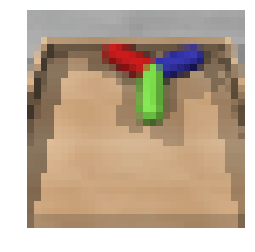


========== IMAGE # 12 =========
POS (cm) ERROR: 0.5879641986536998

true: [ 0.45451152  0.18676839 -0.17560773 -0.98446022]
pred: [ 0.4279853   0.15790989 -0.16744663 -0.98101836]


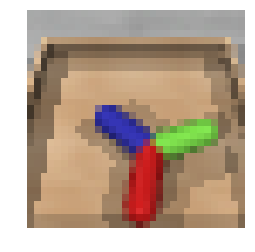


========== IMAGE # 13 =========
POS (cm) ERROR: 0.5879374470983576

true: [-0.89691394  0.21160104 -0.8624927   0.50606951]
pred: [-0.8971894  0.2507959 -0.8582519  0.5286818]


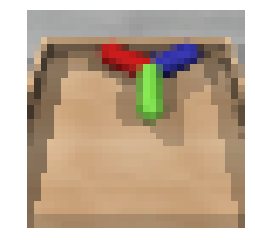


========== IMAGE # 14 =========
POS (cm) ERROR: 0.5780582728659913

true: [ 0.66432474  0.33550318 -0.5568951  -0.83058284]
pred: [ 0.66541827  0.29698148 -0.5725831  -0.8320163 ]


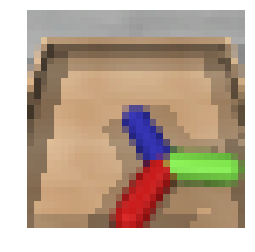


========== IMAGE # 15 =========
POS (cm) ERROR: 0.5778740059445925

true: [ 0.27416698 -0.48426896 -0.19733758  0.9803356 ]
pred: [ 0.25040346 -0.45394626 -0.17788298  0.9762174 ]


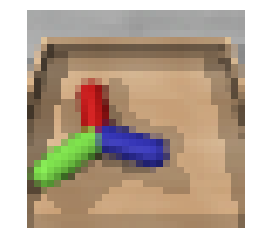


========== IMAGE # 16 =========
POS (cm) ERROR: 0.5692792689919909

true: [-0.89694971  0.21744849 -0.86140809  0.50791348]
pred: [-0.8964015  0.2553965 -0.8571161  0.5266449]


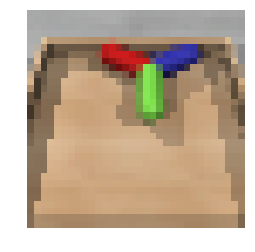


========== IMAGE # 17 =========
POS (cm) ERROR: 0.5682850154927689

true: [ 0.31937764 -0.11800943  0.21477172 -0.97666428]
pred: [ 0.29229933 -0.1445064   0.21632977 -0.97153586]


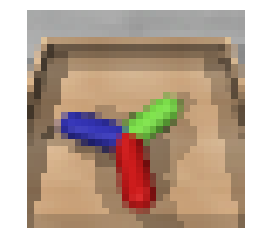


========== IMAGE # 18 =========
POS (cm) ERROR: 0.5657838926599458

true: [ 0.48556408 -0.01383625 -0.04825678 -0.99883496]
pred: [ 0.45845833 -0.04006593 -0.05525538 -0.98751813]


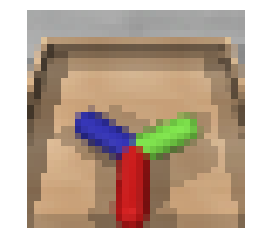


========== IMAGE # 19 =========
POS (cm) ERROR: 0.5636222806651571

true: [ 0.04888486 -0.18594111  0.18808632 -0.9821525 ]
pred: [ 0.03450126 -0.22065392  0.19704042 -0.9742337 ]


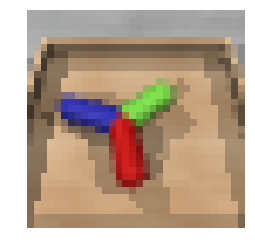

In [11]:
def display_top_errors(errors, label_str=""):
    errors = np.array(errors)
    ind = np.argpartition(errors, -20)[-20:]
    ind = ind[np.argsort(errors[ind])]
    ind = np.flip(ind) # Order descending
    top_errors = errors[ind]
    
    top_error_imgs, top_error_labels, top_error_preds = test_images[ind], test_labels[ind], preds[ind]
    for i, (error, img, label, pred) in enumerate(zip(top_errors,
                                                      top_error_imgs,
                                                      top_error_labels,
                                                      top_error_preds)):
        print('\n========== IMAGE #', i, '=========')
        plt.axis('off')
        plt.imshow(img)
        print('{} ERROR: {}\n\ntrue: {}\npred: {}'.format(label_str, error, label, pred))
        plt.show()
    
display_top_errors(pos_errors, label_str="POS (cm)")


========== IMAGE # 0 =========
ANGLE (degrees) ERROR: 3.3535114631080916

true: [-0.5433606  -0.55412484  0.12334386  0.99236399]
pred: [-0.54824126 -0.5381564   0.18104443  0.98270106]


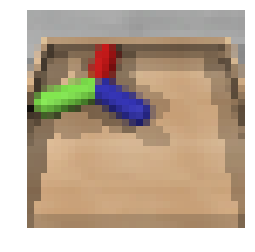


========== IMAGE # 1 =========
ANGLE (degrees) ERROR: 3.344220995347584

true: [-0.49372757 -0.58873174  0.11694387  0.99313853]
pred: [-0.49968082 -0.57018185  0.17476897  0.9851324 ]


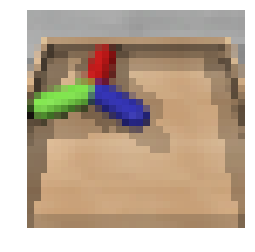


========== IMAGE # 2 =========
ANGLE (degrees) ERROR: 3.110652958703355

true: [-0.54742618 -0.61334478  0.06354323  0.99797909]
pred: [-0.5533265  -0.59712255  0.11689386  0.98706055]


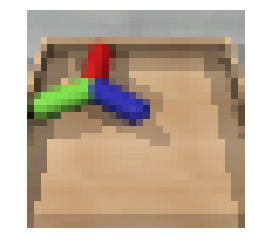


========== IMAGE # 3 =========
ANGLE (degrees) ERROR: 3.09452416707083

true: [-0.56385441 -0.40039682  0.2201204   0.97547271]
pred: [-0.573176   -0.38638762  0.27442193  0.96910024]


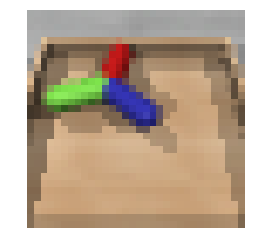


========== IMAGE # 4 =========
ANGLE (degrees) ERROR: 3.0944446644704584

true: [-0.55831328 -0.38174686  0.19602994  0.98059791]
pred: [-0.57254195 -0.36587745  0.2494284   0.9715058 ]


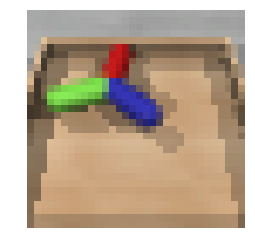


========== IMAGE # 5 =========
ANGLE (degrees) ERROR: 3.0892351102957463

true: [-0.56228773 -0.53526441  0.21792302  0.97596596]
pred: [-0.5660746  -0.5248805   0.27251062  0.9710288 ]


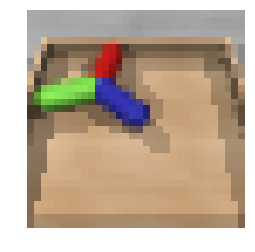


========== IMAGE # 6 =========
ANGLE (degrees) ERROR: 3.077083151984567

true: [-0.50845102 -0.48471295  0.23646028  0.97164116]
pred: [-0.5176833  -0.47799867  0.29140157  0.96792734]


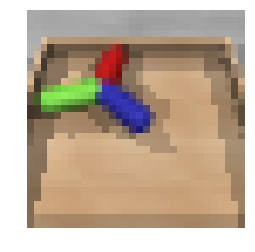


========== IMAGE # 7 =========
ANGLE (degrees) ERROR: 3.03705911416597

true: [-0.43699497 -0.60101949  0.09394236  0.99557764]
pred: [-0.44945484 -0.59108794  0.14625368  0.9871479 ]


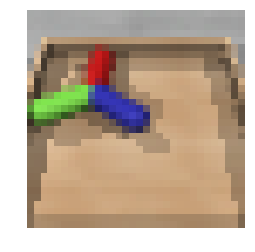


========== IMAGE # 8 =========
ANGLE (degrees) ERROR: 2.978360435780587

true: [-0.55677709 -0.57637168  0.1779013   0.98404834]
pred: [-0.5676452  -0.5687968   0.2297019   0.97735167]


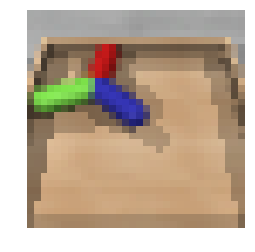


========== IMAGE # 9 =========
ANGLE (degrees) ERROR: 2.9485933077874193

true: [-0.55660548 -0.57592327  0.17868406  0.9839065 ]
pred: [-0.5676223  -0.5687479   0.22998272  0.9773352 ]


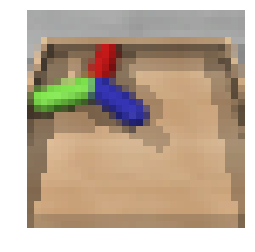


========== IMAGE # 10 =========
ANGLE (degrees) ERROR: 2.934831945006792

true: [-0.36225098 -0.58149495  0.1447063   0.98947465]
pred: [-0.37162283 -0.57047826  0.19570397  0.9834126 ]


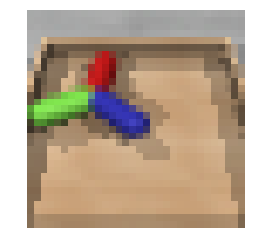


========== IMAGE # 11 =========
ANGLE (degrees) ERROR: 2.9211663690860235

true: [-0.55708413 -0.57599666  0.17962389  0.98373536]
pred: [-0.56771505 -0.5688026   0.23046342  0.9772888 ]


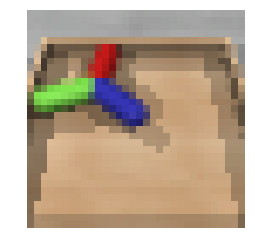


========== IMAGE # 12 =========
ANGLE (degrees) ERROR: 2.9171522920033794

true: [-0.56031312 -0.38079281  0.16898419  0.98561876]
pred: [-0.57202137 -0.35911953  0.219069    0.97638214]


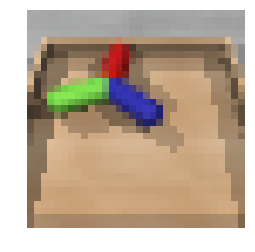


========== IMAGE # 13 =========
ANGLE (degrees) ERROR: 2.88784808650135

true: [-0.48223133 -0.61252059  0.03588802  0.99935582]
pred: [-0.4924867  -0.59916335  0.08559352  0.9893708 ]


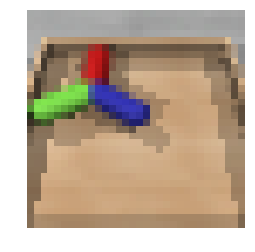


========== IMAGE # 14 =========
ANGLE (degrees) ERROR: 2.8743713580951322

true: [-0.55380073 -0.58675153  0.07588443  0.99711662]
pred: [-0.568293   -0.5735708   0.12507182  0.9863881 ]


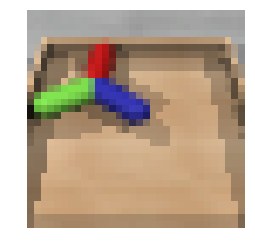


========== IMAGE # 15 =========
ANGLE (degrees) ERROR: 2.8622771730791214

true: [-0.5501396  -0.52004636  0.10610359  0.99435508]
pred: [-0.56000483 -0.50782347  0.15491387  0.9833046 ]


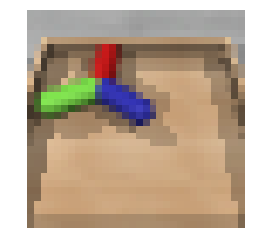


========== IMAGE # 16 =========
ANGLE (degrees) ERROR: 2.8482090936840336

true: [-0.55247626 -0.59801754  0.10396444  0.99458102]
pred: [-0.5576894  -0.58343065  0.15287706  0.9857374 ]


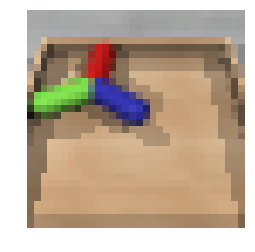


========== IMAGE # 17 =========
ANGLE (degrees) ERROR: 2.787077951959759

true: [-0.37954659 -0.59485463  0.11076999  0.99384607]
pred: [-0.39236566 -0.5884193   0.15877472  0.9861074 ]


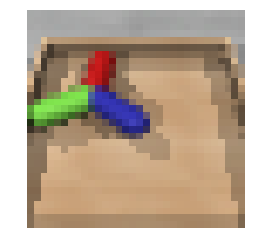


========== IMAGE # 18 =========
ANGLE (degrees) ERROR: 2.778053619485277

true: [-0.55301691 -0.56827517  0.21768878  0.97601824]
pred: [-0.5681914  -0.5633819   0.267364    0.97388643]


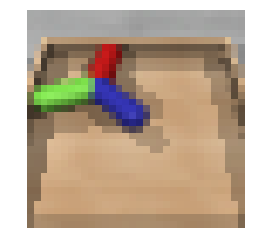


========== IMAGE # 19 =========
ANGLE (degrees) ERROR: 2.772724437459118

true: [-0.57981046 -0.35269666  0.29400322  0.95580443]
pred: [-0.58358383 -0.3368564   0.34489498  0.9542966 ]


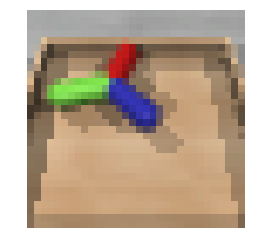

In [12]:
display_top_errors(angle_errors, label_str="ANGLE (degrees)")

In [11]:
first = np.arctan2(-0.23606753, -0.97173665)
second = np.arctan2(0.17438738, -0.9635754)
rad_to_deg = lambda x: 180 * x / np.pi
rad_to_deg(first), rad_to_deg(second)

(-166.34544160951023, 169.74167643493442)

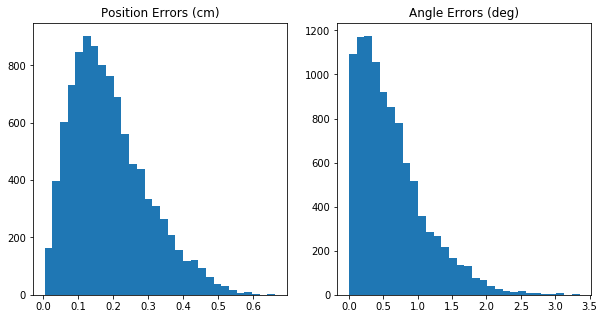

In [13]:
def plot_histograms(pos_errors, angle_errors):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Position Errors (cm)')
    plt.hist(pos_errors, bins=30)
    plt.subplot(1, 2, 2)
    plt.title('Angle Errors (deg)')
    plt.hist(angle_errors, bins=30)
    plt.show()
    
plot_histograms(pos_errors, angle_errors)

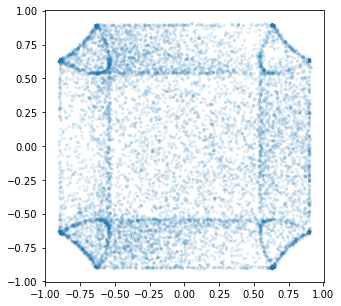

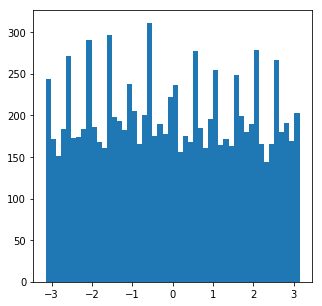

In [17]:
def plot_pos_support():
    plt.figure(figsize=(5, 5))
    plt.scatter(test_labels[:, 0], test_labels[:, 1], alpha=0.1, s=5)
    plt.show()
    
plot_pos_support()

def plot_angle_support():
    plt.figure(figsize=(5,5))
    angles = np.arctan2(test_labels[:, 3], test_labels[:, 2])
    plt.hist(angles, bins=50)
    plt.show()
    
plot_angle_support()

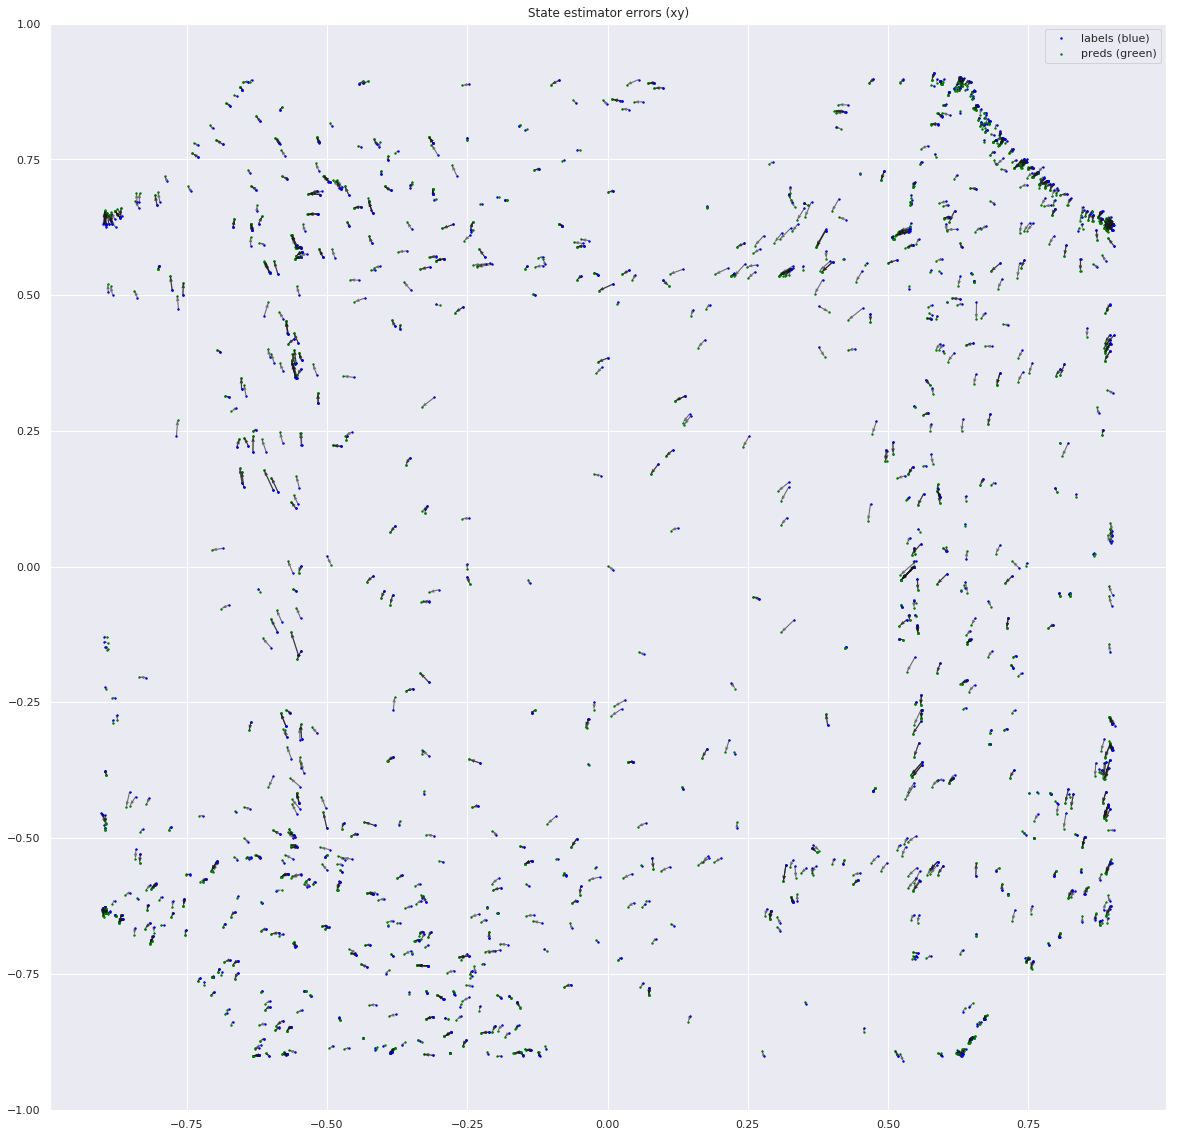

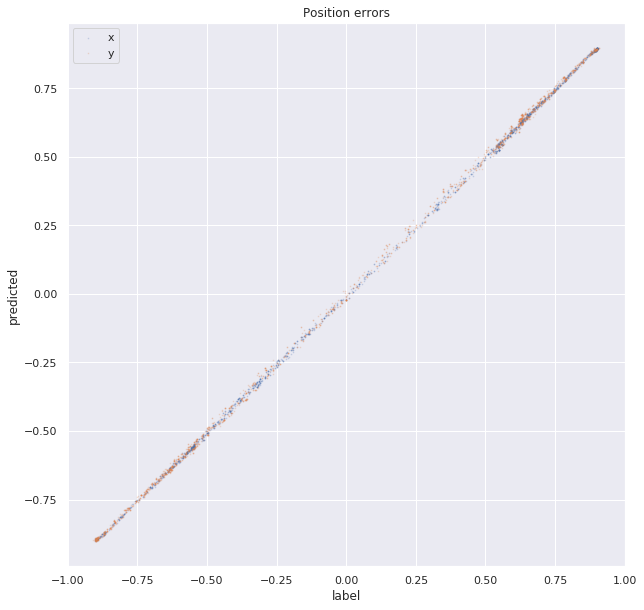

In [9]:
# for label, pred in zip(test_labels, preds):
#     labels_x, labels_y = test_labels[:, 0], test_labels[:, 1]
#     preds_x, preds_y = preds[:, 0], preds[:, 1]
#     print(preds_x.shape, preds_y.shape)
#     dxs, dys = preds_x - labels_x, preds_y - labels_y
#     print(dxs.shape, dys.shape)

import seaborn as sns
sns.set()
def get_noise(size, loc=0, scale=0.02):
    return np.random.normal(loc=loc, scale=scale, size=size)

labels_x, labels_y = test_labels[:, 0], test_labels[:, 1]

# noisy_x, noisy_y = (
#     test_labels[:, 0] + get_noise(test_labels[:, 0].shape),
#     test_labels[:, 1] + get_noise(test_labels[:, 1].shape),
# )
# dxs_noise, dys_noise = noisy_x - labels_x, noisy_y - labels_y
# plt.figure(figsize=(20, 20))
# plt.quiver(labels_x, labels_y, dxs_noise, dys_noise, angles='xy', scale_units='xy', scale=1, width=0.001, alpha=0.5)

preds_x, preds_y = preds[:, 0], preds[:, 1]
dxs, dys = preds_x - labels_x, preds_y - labels_y
plt.figure(figsize=(20, 20))
plt.title('State estimator errors (xy)')

plt.scatter(labels_x, labels_y, c='blue', s=2, label='labels (blue)')
plt.scatter(preds_x, preds_y, c='green', s=2, label='preds (green)')
plt.legend()
plt.quiver(labels_x, labels_y, dxs, dys, angles='xy', scale_units='xy', scale=1, width=0.001, alpha=0.6)

plt.figure(figsize=(10, 10))
plt.title('Position errors')
plt.xlabel('label')
plt.ylabel('predicted')

plt.scatter(labels_x, preds_x, s=0.5, alpha=0.2, label='x')
plt.scatter(labels_y, preds_y, s=0.5, alpha=0.2, label='y')
plt.legend()


[-1.64558821  2.40216463 -0.53519477 ...  0.29115071  0.32738294
  1.74056645] [-1.64558821  2.40216463 -0.53519477 ...  0.29115071  0.32738294
  1.74056645]


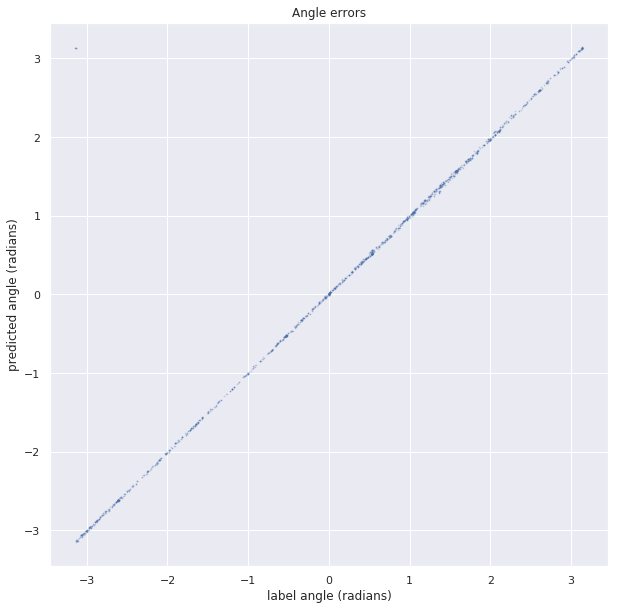

In [10]:
labels_z_cos, labels_z_sin = test_labels[:, 2], test_labels[:, 3]
preds_z_cos, preds_z_sin = preds[:, 2], preds[:, 3]
dzs_cos, dzs_sin = preds_z_cos - labels_z_cos, preds_z_sin - labels_z_sin

# plt.figure(figsize=(20, 20))
# plt.title('State estimator errors (angle)')
# plt.scatter(labels_z_cos, labels_z_sin, c='blue', s=2, label='labels (blue)')
# plt.scatter(preds_z_cos, preds_z_sin, c='green', s=2, label='preds (green)')
# plt.legend()
# # circle = plt.Circle((0, 0), 1, color='black', alpha=.5, fill=False)
# # plt.gcf().gca().add_artist(circle)
# plt.quiver(labels_z_cos, labels_z_sin, dzs_cos, dzs_sin, angles='xy', scale_units='xy', scale=1, width=0.001, alpha=0.6)

labels_angle, preds_angle = (
    np.arctan2(labels_z_sin, labels_z_cos),
    np.arctan2(preds_z_sin, preds_z_cos)
)
print(labels_angle, labels_angle)
plt.figure(figsize=(10, 10))
plt.title('Angle errors')
plt.xlabel('label angle (radians)')
plt.ylabel('predicted angle (radians)')
plt.scatter(labels_angle, preds_angle, s=0.4, alpha=0.25)
